In [9]:
# From here https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Download training data from open datasets.
train_dataset = datasets.CIFAR10(
    train=True,
    root="data",
    download=True,
    transform=ToTensor(),
)

test_dataset = datasets.CIFAR10(
    train=False,
    root="data",
    download=True,
    transform=ToTensor(),
)

class TwoClassDataset(Dataset):
    def __init__(self, original_dataset, class_indices, transform=None):
        self.original_dataset = original_dataset
        self.class_indices = class_indices
        self.filtered_indices = self._filter_indices()

    def _filter_indices(self):
        # Filter indices based on selected classes
        return [idx for idx in range(len(self.original_dataset)) if self.original_dataset[idx][1] in self.class_indices]

    def __len__(self):
        return len(self.filtered_indices)

    def __getitem__(self, idx):
        # Get the item from the original dataset using filtered indices
        original_idx = self.filtered_indices[idx]
        sample, target = self.original_dataset[original_idx]

        # Map the original class indices to new indices
        target = self.class_indices.index(target)
        return sample, target

selected_classes = [1, 3]  

# Create a new dataset with only the selected classes
train_data = TwoClassDataset(train_dataset, selected_classes)

# change this to be a validation set, taken from the training, with test only used at the end
test_data = TwoClassDataset(test_dataset, selected_classes)

x, y = test_data[0][0], test_data[0][1]
print(f"x : {x}, y: {y}")

batch_size = 64

# Create data loaders
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break


Using cpu device
Files already downloaded and verified
Files already downloaded and verified
x : tensor([[[0.6196, 0.6235, 0.6471,  ..., 0.5373, 0.4941, 0.4549],
         [0.5961, 0.5922, 0.6235,  ..., 0.5333, 0.4902, 0.4667],
         [0.5922, 0.5922, 0.6196,  ..., 0.5451, 0.5098, 0.4706],
         ...,
         [0.2667, 0.1647, 0.1216,  ..., 0.1490, 0.0510, 0.1569],
         [0.2392, 0.1922, 0.1373,  ..., 0.1020, 0.1137, 0.0784],
         [0.2118, 0.2196, 0.1765,  ..., 0.0941, 0.1333, 0.0824]],

        [[0.4392, 0.4353, 0.4549,  ..., 0.3725, 0.3569, 0.3333],
         [0.4392, 0.4314, 0.4471,  ..., 0.3725, 0.3569, 0.3451],
         [0.4314, 0.4275, 0.4353,  ..., 0.3843, 0.3725, 0.3490],
         ...,
         [0.4863, 0.3922, 0.3451,  ..., 0.3804, 0.2510, 0.3333],
         [0.4549, 0.4000, 0.3333,  ..., 0.3216, 0.3216, 0.2510],
         [0.4196, 0.4118, 0.3490,  ..., 0.3020, 0.3294, 0.2627]],

        [[0.1922, 0.1843, 0.2000,  ..., 0.1412, 0.1412, 0.1294],
         [0.2000, 0.1569, 

In [10]:

# Define model
# nn.Module is the Base class for all neural network modules
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

# To train the model we need a loss function and an optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


# Invoke lists for the accuracy and loss values at the end of each epoch
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# We define training including the predictions and backpropagations

def train(dataloader, model, loss_fn, optimizer):
    epoch_losses, epoch_accuracies = [], []
    size = len(dataloader.dataset) # why do we need this? 
    model.train() # sets the module in training mode
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Use the loss function to update the weights 
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0: # % is remainder 
        # this prints a result every 100 items 
            batch_loss, current = loss.item(), (batch + 1) * len(X)
            print(f"batch number: {batch}, loss: {batch_loss:>7f} [{current:>5d}/{size:>5d}]")
            epoch_losses.append(batch_loss)
    
    epoch_loss = np.array(epoch_losses).mean()
    train_losses.append(epoch_loss)

def test(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0 
    with torch.no_grad(): # context manager that disables gradient calculation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    test_losses.append(test_loss)
    correct /= size
    print(f"Test Error: \nAccuracy: {(100*correct):>0.1f}, Avg loss: {test_loss:>8f} \n")


# Conduct training over several epochs
if __name__ == '__main__':
    epochs = 20
    for t in range(epochs):
        print(f"Epoch {t+1}\n---------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        test(test_dataloader, model, loss_fn, optimizer)
    print("Done!")
    print('Train losses', train_losses)
    print('Test losses', test_losses)


    torch.save(model.state_dict(), "model.pth")
    print("Saved PyTorch Model State to model.pth")





NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Epoch 1
---------------------
batch number: 0, loss: 2.317953 [   64/10000]
batch number: 100, loss: 1.544761 [ 6464/10000]
Test Error: 
Accuracy: 58.8, Avg loss: 1.039388 

Epoch 2
---------------------
batch number: 0, loss: 1.029235 [   64/10000]
batch number: 100, loss: 0.805737 [ 6464/10000]
Test Error: 
Accuracy: 70.7, Avg loss: 0.748107 

Epoch 3
---------------------
batch number: 0, loss: 0.748445 [   64/10000]
batch number: 100, loss: 0.725353 [ 6464/10000]
Test Error: 
Accuracy: 72.3, Avg loss: 0.699400 

Epoch 4
---------------------
batch number: 0, loss: 0.704363 [   64/10000]
batch number: 100, loss: 0.696124 [ 6464/10000]
Test Error: 
Accuracy: 72.5, Avg l

In [11]:
import matplotlib.pyplot as plt

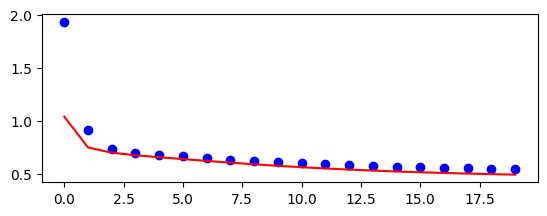

In [12]:
plt.subplot(211)
plt.plot(train_losses, 'bo', label='Training loss')
plt.plot(test_losses, 'r', label='Validation loss')